In [1]:
# 1. Import library
import numpy as np
import pandas as pd
from sklearn.model_selection import GridSearchCV, LeaveOneOut
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from skimage.feature import hog
from sklearn.utils import shuffle
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# 2. Load dan preprocessing data
df = pd.read_csv("emnist-letters-test.csv", header=None)
labels = df.iloc[:, 0].values
images = df.iloc[:, 1:].values.reshape(-1, 28, 28).astype(np.uint8)


In [5]:
# Ambil 100 sampel per huruf dari A-J (label 1-10)
selected_images = []
selected_labels = []
for label in range(1, 11):
    idx = np.where(labels == label)[0][:100]
    selected_images.extend(images[idx])
    selected_labels.extend(labels[idx])

selected_images = np.array(selected_images)
selected_labels = np.array(selected_labels)

In [7]:
# Shuffle data
X, y = shuffle(selected_images, selected_labels, random_state=42)

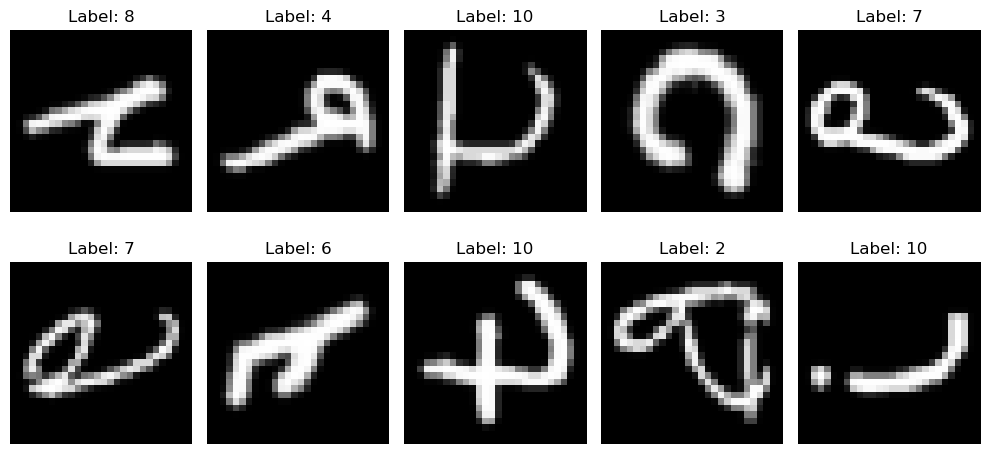

In [9]:
# Visualisasi beberapa gambar
start = 100
fig, axes = plt.subplots(2, 5, figsize=(10, 5))
for i, ax in enumerate(axes.flat):
    ax.imshow(X[start + i], cmap='gray')
    ax.set_title(f"Label: {y[start + i]}")
    ax.axis('off')
plt.tight_layout()
plt.show()

In [11]:
# Informasi dataset
print("Jumlah Data:", len(images))
print("Dimensi Gambar:", images[0].shape)


Jumlah Data: 14800
Dimensi Gambar: (28, 28)


In [13]:
# 3. Ekstraksi fitur HOG
hog_params = {
    'orientations': 9,
    'pixels_per_cell': (8, 8),
    'cells_per_block': (2, 2),
    'block_norm': 'L2-Hys'
}

hog_features = [hog(img, **hog_params) for img in X]
hog_features = np.array(hog_features)


In [15]:
# 4. GridSearch untuk parameter terbaik SVM
param_grid = {
    'C': [1, 10],
    'gamma': [0.001, 0.01],
    'kernel': ['rbf', 'poly']
}

svm = SVC()
grid = GridSearchCV(svm, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid.fit(hog_features, y)
print("Best SVM Parameters:", grid.best_params_)

Best SVM Parameters: {'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}


In [17]:
# 5. Evaluasi dengan LOOCV
loo = LeaveOneOut()
y_true, y_pred = [], []

print("Evaluasi LOOCV...")
for train_idx, test_idx in tqdm(loo.split(hog_features), total=len(hog_features)):
    X_train, X_test = hog_features[train_idx], hog_features[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    clf = SVC(**grid.best_params_)
    clf.fit(X_train, y_train)
    pred = clf.predict(X_test)

    y_true.append(y_test[0])
    y_pred.append(pred[0])

Evaluasi LOOCV...


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:50<00:00,  9.01it/s]


In [18]:
# 6. Evaluasi hasil
acc = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred, average='macro', zero_division=0)
rec = recall_score(y_true, y_pred, average='macro', zero_division=0)
f1 = f1_score(y_true, y_pred, average='macro', zero_division=0)
conf = confusion_matrix(y_true, y_pred)

print(f"\nAccuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"F1-Score:  {f1:.4f}")



Accuracy:  0.7830
Precision: 0.7839
Recall:    0.7830
F1-Score:  0.7815


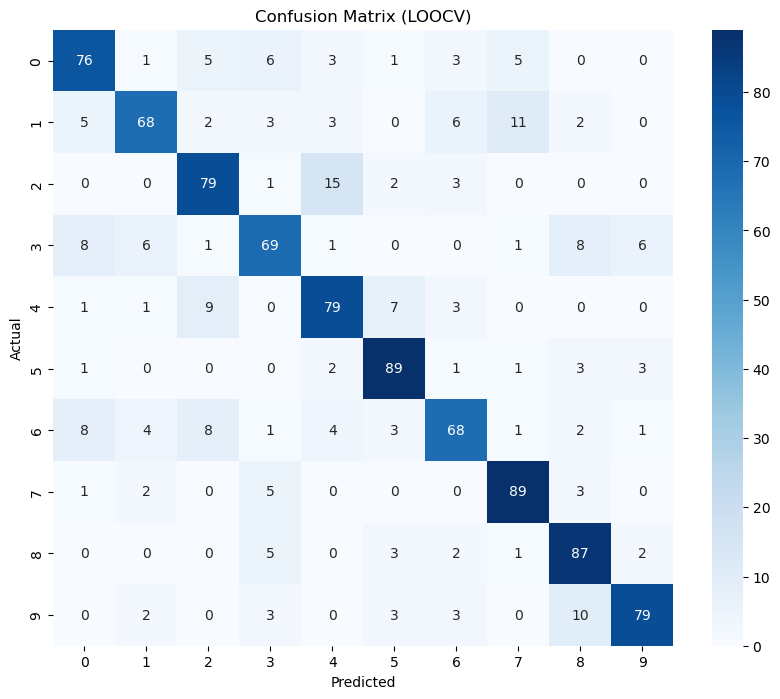

In [19]:
# 7. Tampilkan confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix (LOOCV)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()